In [2]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *

In [4]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

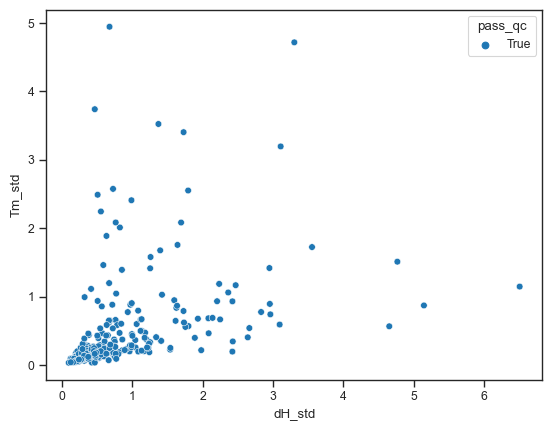

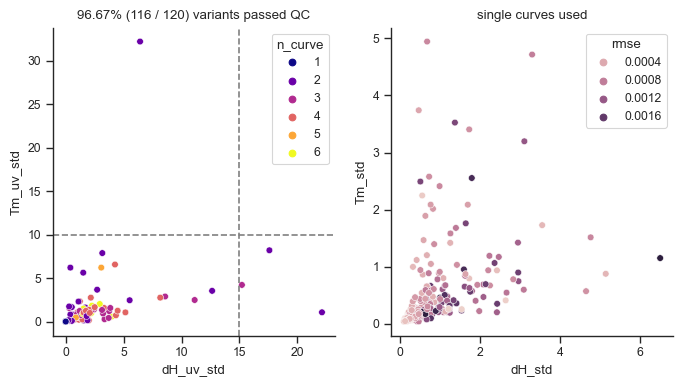

In [6]:
sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

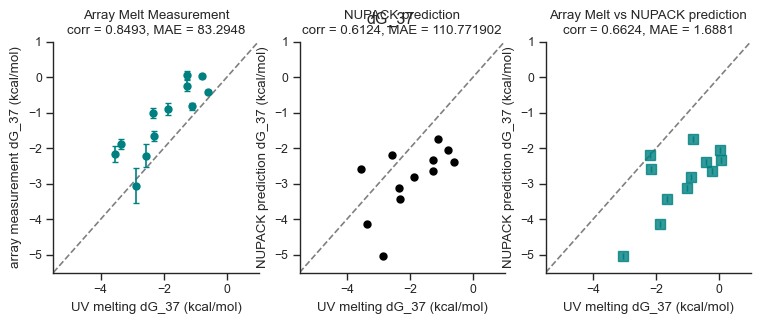

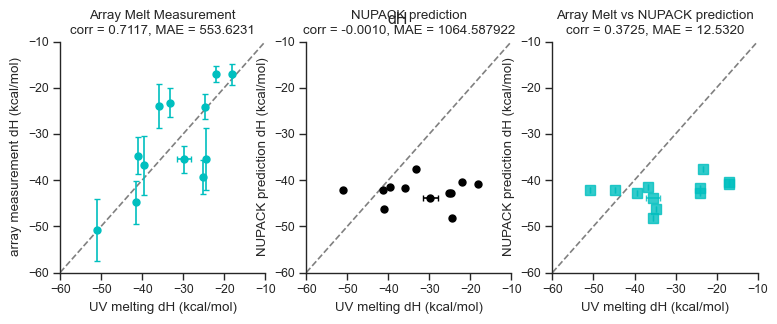

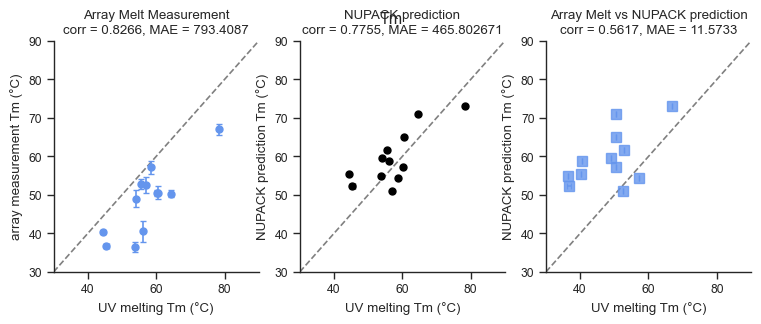

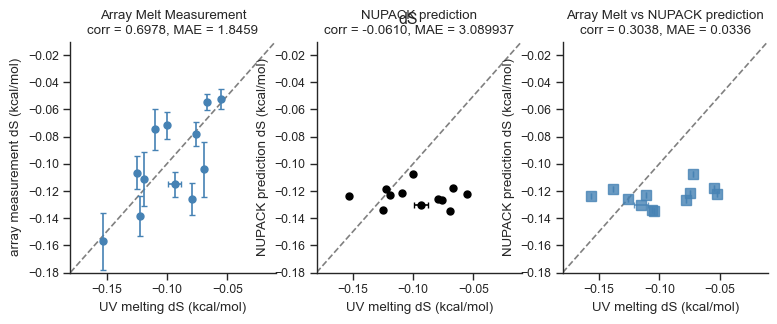

In [4]:
"""
For in the notebook
"""
series = 'All'
plot_query = 'n_curve > 0'
df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    color_dict = dict(dH='c', Tm='cornflowerblue', dG_37='teal', dS='steelblue')
    unit = unit_dict[param]
    
    kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=5, capsize=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})')
    ax[0].set_ylabel(f'array measurement {param} ({unit})')
    ax[0].set_title('Array Melt Measurement\ncorr = %.4f, MAE = %.4f' %
                    (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   color='k', **kwargs)
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})')
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[1].set_title('NUPACK prediction\ncorr = %.4f, MAE = %4f' %
                    (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    kwargs['marker'] = 's'
    kwargs['markersize'] = 7
    kwargs['alpha'] = 0.8
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               color=color_dict[param], **kwargs)
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})')
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
                    (pearsonr(x, y)[0], mae(x, y)))
    
    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-5.5, 1))
# util.save_fig(f'./fig/UV_melt/Fig2b/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
# util.save_fig(f'./fig/UV_melt/Fig2b/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (30, 90))
# util.save_fig(f'./fig/UV_melt/Fig2b/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.18, -.01))
# util.save_fig(f'./fig/UV_melt/Fig2b/{series}_dS.pdf')

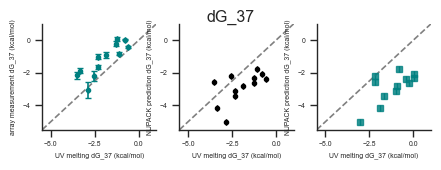

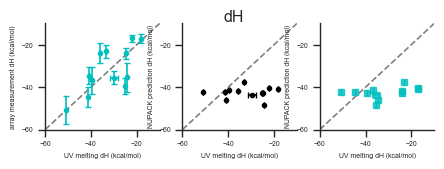

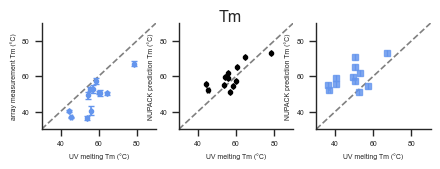

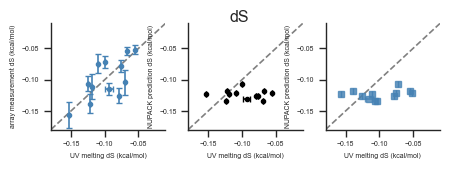

In [125]:
# for export
series = 'All'
plot_query = 'n_curve > 0'
df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    color_dict = dict(dH='c', Tm='cornflowerblue', dG_37='teal', dS='steelblue')
    param_name_dict = dict(dH=r'$dH°$', dS=r'$dS°$', dG_37=r'$dG°_{37}$', Tm=r'$T_m$')
    unit = unit_dict[param]
    param_name = param_name_dict[param]
    
    kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=3, capsize=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(3*4.25*cm, 3.5*cm))
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[0].set_ylabel(f'array measurement {param} ({unit})', fontsize=tick_font_size)
    # ax[0].set_title('Array Melt Measurement\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))
    
    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   color='k', **kwargs)
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[1].set_title('NUPACK prediction\ncorr = %.4f, MAE = %4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    kwargs['marker'] = 's'
    kwargs['markersize'] = 5
    kwargs['alpha'] = 0.8
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               color=color_dict[param], **kwargs)
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae(x, y)))
    for i in range(3):
        ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=tick_font_size)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=tick_font_size)

    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-5.5, 1))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (30, 90))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.18, -.01))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dS.pdf')

(-4.0, 0.0)

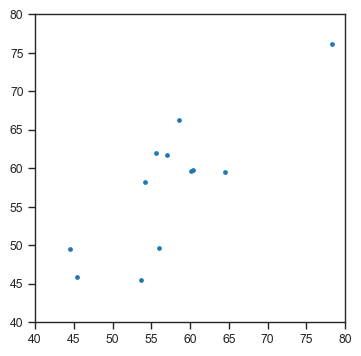

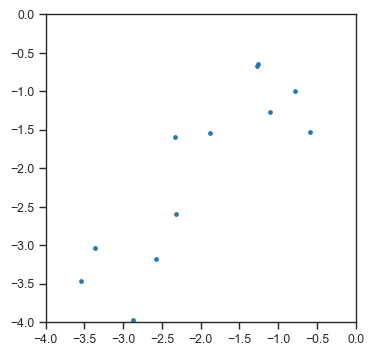

In [21]:
dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

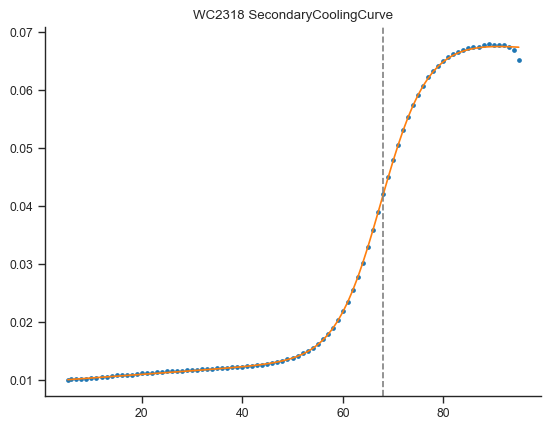

In [74]:
row = result_df.query('rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120').sort_values(by='rmse').iloc[4,:]
curve = uv.plot_curve_fit_result(row, return_curve=True)

In [101]:
df_2a = result_df.query('curve_date == 22071204 & curve_num == 7')

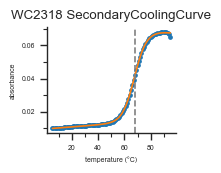

In [114]:
"""
for export
"""
df_2a = result_df.query('curve_date == 22071204 & curve_num == 7')

fn = row['data_file']
blanked_fn = get_blanked_fn(fn)
if os.path.isfile(blanked_fn):
    fn = blanked_fn
curve = read_curve(fn)
curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))

row = df_2a.iloc[2,:]
ax.plot(curve.celsius, curve.absorbance, '.')
ax.plot(curve.celsius, 
         curve_predict - curve_predict[0] + curve.absorbance[0])
ax.axvline(row['Tm'], linestyle='--', c='gray')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

if 'SEQID' in row.index:
    plt.title('%s %s' % (row['SEQID'], row['curve_name']))
else:
    plt.title('%s' % (row['data_file']))
sns.despine()

util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_curve_WC2318.pdf')

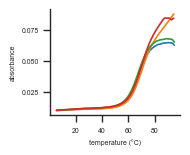

In [122]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
for _,row in df_2a.iterrows():
    curve = read_curve(get_blanked_fn(row['data_file']))
    # curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})
    ax.plot(curve.celsius, curve.absorbance)
    
ax.xaxis.set_major_locator(MultipleLocator(20))


ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

sns.despine()
util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_all_curves_WC2318.pdf')

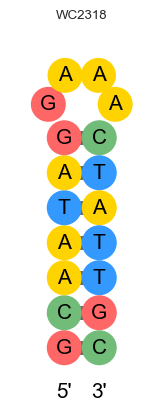

In [90]:
plotting.draw_target_struct('WC2318', arr)
util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_curve_WC2318_struct.pdf')

In [135]:
def get_param_err(param):
    x = df_q[param + '_uv']
    y = df_q[param+'']
    result = pearsonr(x, y)[0]
    return result

get_param_err('dG_37')

0.8492642960243385

In [267]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)

with open('./data/models/raw/train_val_test_split.json', 'r') as fh:
    tvt_split = json.load(fh)
with open('./data/models/raw/train_val_test_split.json', 'r') as fh:
    data_split_dict = json.load(fh)

In [139]:
import umap

In [136]:
dist_mat = np.load('./data/models/processed/distance_mat_train_train_struct.npy')

In [238]:
%%time
np.random.seed(42)
embedding = umap.UMAP(n_neighbors=9,
                      min_dist=1,
                      metric='euclidean').fit_transform(dist_mat)

CPU times: user 42 s, sys: 5.15 s, total: 47.1 s
Wall time: 15.8 s


In [239]:
df_plot = arr.loc[tvt_split['train_ind'], ['dG_37', 'Tm', 'dH', 'Series']]
df_plot[['UMAP_1', 'UMAP_2']] = embedding

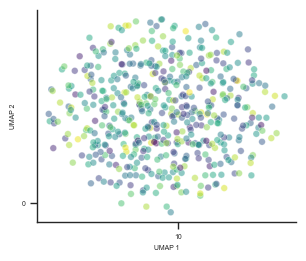

In [248]:
fig, ax = plt.subplots(figsize=(2*4.25*cm, 2*3.5*cm))
sns.scatterplot(data=df_plot, x='UMAP_1', y='UMAP_2', hue='dG_37', 
                alpha=0.5, style='Series', palette='viridis',
                rasterized=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('UMAP 1', fontsize=tick_font_size)
ax.set_ylabel('UMAP 2', fontsize=tick_font_size)
ax.get_legend().remove()
sns.despine()

util.save_fig('./fig/Fig2/Fig2c/umap_all_bs.pdf')

In [243]:
arr_train = arr.loc[tvt_split['train_ind'], :]

ind = np.where(arr_train.eval('Series == "TRIloop" & ConstructType == "NNN"'))[0].flatten()

In [244]:
%%time
np.random.seed(42)
embedding = umap.UMAP(n_neighbors=8,
                      min_dist=1,
                      metric='euclidean').fit_transform(dist_mat[ind, :][:, ind])

CPU times: user 8.61 s, sys: 597 ms, total: 9.2 s
Wall time: 2.59 s


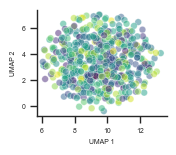

In [247]:
df_plot = arr.loc[tvt_split['train_ind'], ['dG_37', 'Tm', 'dH', 'Series', 'GC']].iloc[ind,:]
df_plot[['UMAP_1', 'UMAP_2']] = embedding

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
sns.scatterplot(data=df_plot, x='UMAP_1', y='UMAP_2', hue='dG_37', #size='GC',
                alpha=0.5, palette='viridis',
                rasterized=True)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('UMAP 1', fontsize=tick_font_size)
ax.set_ylabel('UMAP 2', fontsize=tick_font_size)
ax.get_legend().remove()
sns.despine()

util.save_fig('./fig/Fig2/Fig2c/umap_triloop_bs.pdf')

In [259]:
result_agg_df = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last')

In [374]:
result_agg_df_test = result_agg_df.loc[~result_agg_df.SEQID.isin(tvt_split['train_ind'])].query('dG_37_uv_std < 1')

In [375]:
result_agg_df_test.shape

(17, 16)

In [265]:
import nnn.motif_fit as mf

In [274]:
arr, data_split_dict = fileio.read_ml_data('./data/models/raw', append_2_arr=True)

with open('./data/uv_melt/correction.pkl', 'rb') as fh:
    correction_dict = pickle.load(fh)

santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr['dG_37'] = uv.correct_param(arr, correction_dict, 'dG_37')

feats = mf.get_feature_count_matrix(arr, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
lr = mf.fit_param(arr, data_split_dict, param='dG_37', feats=feats, ax=ax, mode='val')

<Figure size 640x480 with 0 Axes>

In [350]:
plot_query = 'Na_mM == 25 & is_hairpin'
df_q = result_agg_df_test.query(plot_query)
# df_q['seqidnum'] = df_q['SEQID'].apply(lambda x: int(x[2:]))
# df_q = df_q.sort_values(by='seqidnum')

In [351]:
oligos = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv', index_col=0)

In [376]:
arr_test = pd.DataFrame(columns=arr.columns, index=result_agg_df_test.SEQID)

arr_test.RefSeq = result_agg_df_test[['SEQID']].apply(lambda x: oligos.loc[x, 'sequence'])

def get_targetstruct(seqid, seq):
    if seqid in arr.index:
        return arr.loc[seqid, 'TargetStruct']
    else:
        n = len(seq)
        n_stem = int((n - 4) / 2)
        return '('*n_stem + '....' + ')'*n_stem

arr_test.TargetStruct = arr_test.apply(lambda row: get_targetstruct(row.name, row.RefSeq), axis=1)

In [330]:
arr_all = pd.concat((arr, arr_test), axis=0)
feats = mf.get_feature_count_matrix(arr_all, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
lr = mf.fit_param(arr_all, data_split_dict, param='dG_37', feats=feats, ax=ax, mode='val')

ValueError: array must not contain infs or NaNs

In [377]:
from nnn import feature_list
preds = []
for i,q_row in arr_test.iterrows():
    q_feat_list = feature_list.get_feature_list(q_row, fit_intercept=False, symmetry=False, sep_base_stack=True)
    try:
        pred = lr.coef_df.loc[q_feat_list].sum().values[0]
    except:
        pred = np.nan
    preds.append(pred)

In [378]:
result_agg_df_test['pred'] = preds

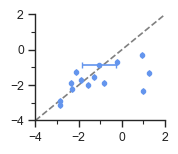

In [379]:
kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=3, capsize=2)
lim = (-4, 2)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
x = result_agg_df_test.dG_37_uv
y = result_agg_df_test.pred
xerr = result_agg_df_test.dG_37_uv_std
ax.plot(lim, lim, '--', c='gray')
ax.errorbar(x, y,
           xerr=xerr,
           color='cornflowerblue', **kwargs)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.xlim(lim)
plt.ylim(lim)
sns.despine()


In [278]:
color_dict = dict(dH='c', Tm='cornflowerblue', dG_37='teal', dS='steelblue')
test_data = dict(
    X=feats.loc[df_q.SEQID,:].values,
    y=df_q['dG_37'].values,
    y_err=df_q['dG_37_std'].values,
    param='dG_37',
    split='UV melting'
)
param = 'dG_37'

# y_pred = lr.predict(test_data['X'])
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)
lim = (-4.5,-1.5)
kwargs = dict(alpha=1, lim=lim, marker='o', markersize=5, capsize=2)
plotting.plot_truth_predict(lr, test_data, ax=ax[0], title='NNN OLS model',
                        color=color_dict[param], **kwargs)
plotting.plot_truth_predict(None, test_data, ax=ax[1], title='NUPACK model',
                            nupack_prediction=df_q['dG_37_NUPACK_salt_corrected'],
                        color=color_dict['dS'], **kwargs)
ax[1].set_ylabel('')
# util.save_fig('./fig/UV_melt/model_pred_test_NNN_vs_NUPACK.pdf')

KeyError: "['HP014', 'HP016', 'HP018', 'HP019', 'HP023', 'MMCNNN2336', 'BC0', 'HP015', 'HP021', 'HP008', 'HP010', 'MMTM189', 'MMCNNN2337', 'HP005', 'HP007', 'HP003'] not in index"

In [5]:
from nnn.arraydata import ArrayData
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file)
revdata = ArrayData(replicate_df=replicate_df.iloc[3,:],
                   annotation_file=annotation_file)
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file=annotation_file)
annotation = pd.read_table(annotation_file)

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
39.48% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


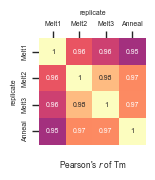

In [15]:
param = 'Tm'
corr_mat = plotting.get_pairwise_pearsonr_matrix([ arraydata.data_all[[param+'-r1']],
                                                   arraydata.data_all[[param+'-r2']],
                                                   arraydata.data_all[[param+'-r3']],
                                                   revdata.data[[param]],
                                                   ])
ticks = ['Melt1', 'Melt2', 'Melt3', 'Anneal']
# mask = np.zeros_like(corr_mat)
# mask[np.tril_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
im = sns.heatmap(corr_mat, vmin=0.92, vmax=0.99, 
                 cmap='magma', cbar=False, linewidths=0, square=True,
                annot=True, annot_kws={'size': 5})
ax.set_xticklabels(ticks, size=tick_font_size)
ax.set_yticklabels(ticks, size=tick_font_size)
ax.set_xlabel('replicate', size=tick_font_size)
ax.set_ylabel('replicate', size=tick_font_size)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_title("Pearson's $r$ of "+param, y=-.3, size=label_font_size)

util.save_fig('./fig/Fig1/Supp/corr_mat_%s.pdf'%param)

# 06/08/2023

In [14]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_adjusted = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)

In [16]:
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr_adjusted, how='left', on='SEQID')
vf = vf.dropna(subset=['Tm', 'dG_37'])

In [26]:
pnames = ['dG_37', 'dH', 'Tm']
mae = [util.mae(vf[p+'_uv'], vf[p]) for p in pnames]

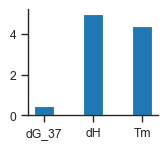

In [36]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
plt.bar(pnames, mae, width = 0.4)
sns.despine()
util.save_fig('./fig/Fig2/MAE_UV.pdf')